# Toronto Fire Services Data Analysis

As anyone who lives in Toronto would tell you, there is always a constant myriad of sirens echoing throughout the 
city. Quantifying the instances of firetrucks speeding down the downtown core is made easy with publicly available data. An easily readable map of the city of Toronto with an overlay of fire incidence per given location would allow any regular citizen to corroborate their everyday findings with real data. 

This project aims to run a breakdown analysis on fire incident data that was collected by the City of Toronto Fire Services. The datasets consist of response time intervals (dispatch, enroute, arrive and clear) and responding units, in additional to the geographical coordinates of the incidents that took place between 2011 and 2017. For privacy purposes personal information is not provided on all incidents and for medical incidents some information has been altered. If data is related to medical incidents the Forward Sortation Area (FSA) is provided in place of the Major Street and Cross Street fields. 

More information can be found at https://open.toronto.ca/dataset/fire-services-basic-incident-details/


![Toronto map](map.png)

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import urllib
import json

from datetime import datetime
from collections import Counter
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import folium
from folium import plugins
import gmaps
import matplotlib.pyplot as plt
%matplotlib inline

### Loading Data from City of Toronto website into

In [9]:
# https://open.toronto.ca/dataset/fire-services-basic-incident-details/
# df = pd.read_csv("/Users/chengh/Documents/projects/TFS/2011-2017_Basic_Incident_Details.csv")

In [3]:
def load_data(url, params):
    
    response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
    package = json.loads(response.read())
    
    for i in range(8):
        zipurl = package["result"].get('resources')[0].get('url')

        z = urlopen(zipurl)
        myzip = ZipFile(BytesIO(z.read())).extract(f'201{i+1}_Basic_Incident_Details.csv')
#         df = pd.read_csv(myzip)
        
        print(f'201{i+1}_Basic_Incident_Details.csv')

In [4]:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "263f54b6-5c60-434f-8958-4e11248f08ff"}

load_data(url=url, params=params)

2011_Basic_Incident_Details.csv
2012_Basic_Incident_Details.csv
2013_Basic_Incident_Details.csv
2014_Basic_Incident_Details.csv
2015_Basic_Incident_Details.csv
2016_Basic_Incident_Details.csv
2017_Basic_Incident_Details.csv
2018_Basic_Incident_Details.csv


In [2]:
files = sorted(glob.glob('*.csv'))

df = [pd.read_csv(filename) for filename in files]

# reading each each year's data into its respective df
for dataframe, filename in zip(df, files):
    dataframe['filename'] = filename
    
# concatenating 8 years of data into one df
df_all = pd.concat([pd.read_csv(f) for f in glob.glob('*.csv')])

In [50]:
# url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
# params = { "id": "263f54b6-5c60-434f-8958-4e11248f08ff"}

# response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
# package = json.loads(response.read())
# package["result"]

# package["result"].get('resources')[0].get('url')

### Data Cleaning & EDA 

CAD: computed aided dispatch event type

Which incident Ward has the most calls 
- During what hours?
- During what seasons? 
- During what months? 
- During what days of the week

Distribution by (incident types / incident ward):
- Year 
- Month 
- Days of week 

#### City of Toronto Wards: 
![Toronto map](wards.png)

In [3]:
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)

In [4]:
df_all.describe()

,Event Alarm Level,Incident Station Area,Incident Ward,LATITUDE,Longitude,Persons Rescued
count,951558.000000,951558.000000,951558.000000,951558.000000,951558.000000,951558.000000
mean,0.110590,282.641222,11.966193,40.559680,-73.683007,0.029022
std,0.321249,107.832516,6.795902,11.295851,20.520704,0.449500
min,0.000000,111.000000,0.000000,0.000000,-79.639456,0.000000
25%,0.000000,214.000000,6.000000,43.656100,-79.456541,0.000000
50%,0.000000,313.000000,12.000000,43.691447,-79.389181,0.000000
75%,0.000000,344.000000,18.000000,43.744150,-79.306824,0.000000
max,6.000000,445.000000,25.000000,43.853169,0.000000,154.000000


In [12]:
m = folium.Map([43.6548, -79.3883])

In [8]:
test_incidents = df_all.sample(10000)

stationArr = test_incidents[['LATITUDE', 'Longitude']].as_matrix()

/Users/chengh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# throughout the 8 years, fires are concetrated at wards 10, 11, and 13 - downtown area

stationArr = test_incidents[['LATITUDE', 'Longitude']].as_matrix()

m.add_children(plugins.HeatMap(stationArr, radius=15))
m

/Users/chengh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/chengh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df_all[["TFS Alarm Time", 
        "TFS Arrival Time", 
        "Last TFS Unit Clear Time"]] = df_all[["TFS Alarm Time", 
                                               "TFS Arrival Time", 
                                               "Last TFS Unit Clear Time"]].apply(pd.to_datetime)


In [19]:
df_all['weekday'] = df_all['TFS Alarm Time'].dt.dayofweek + 1

qual = ['Initial CAD Event Type', 'Initial CAD Event Call Type', 'Final Incident Type', 
       'Event Alarm Level', 'Call Source', 'weekday']

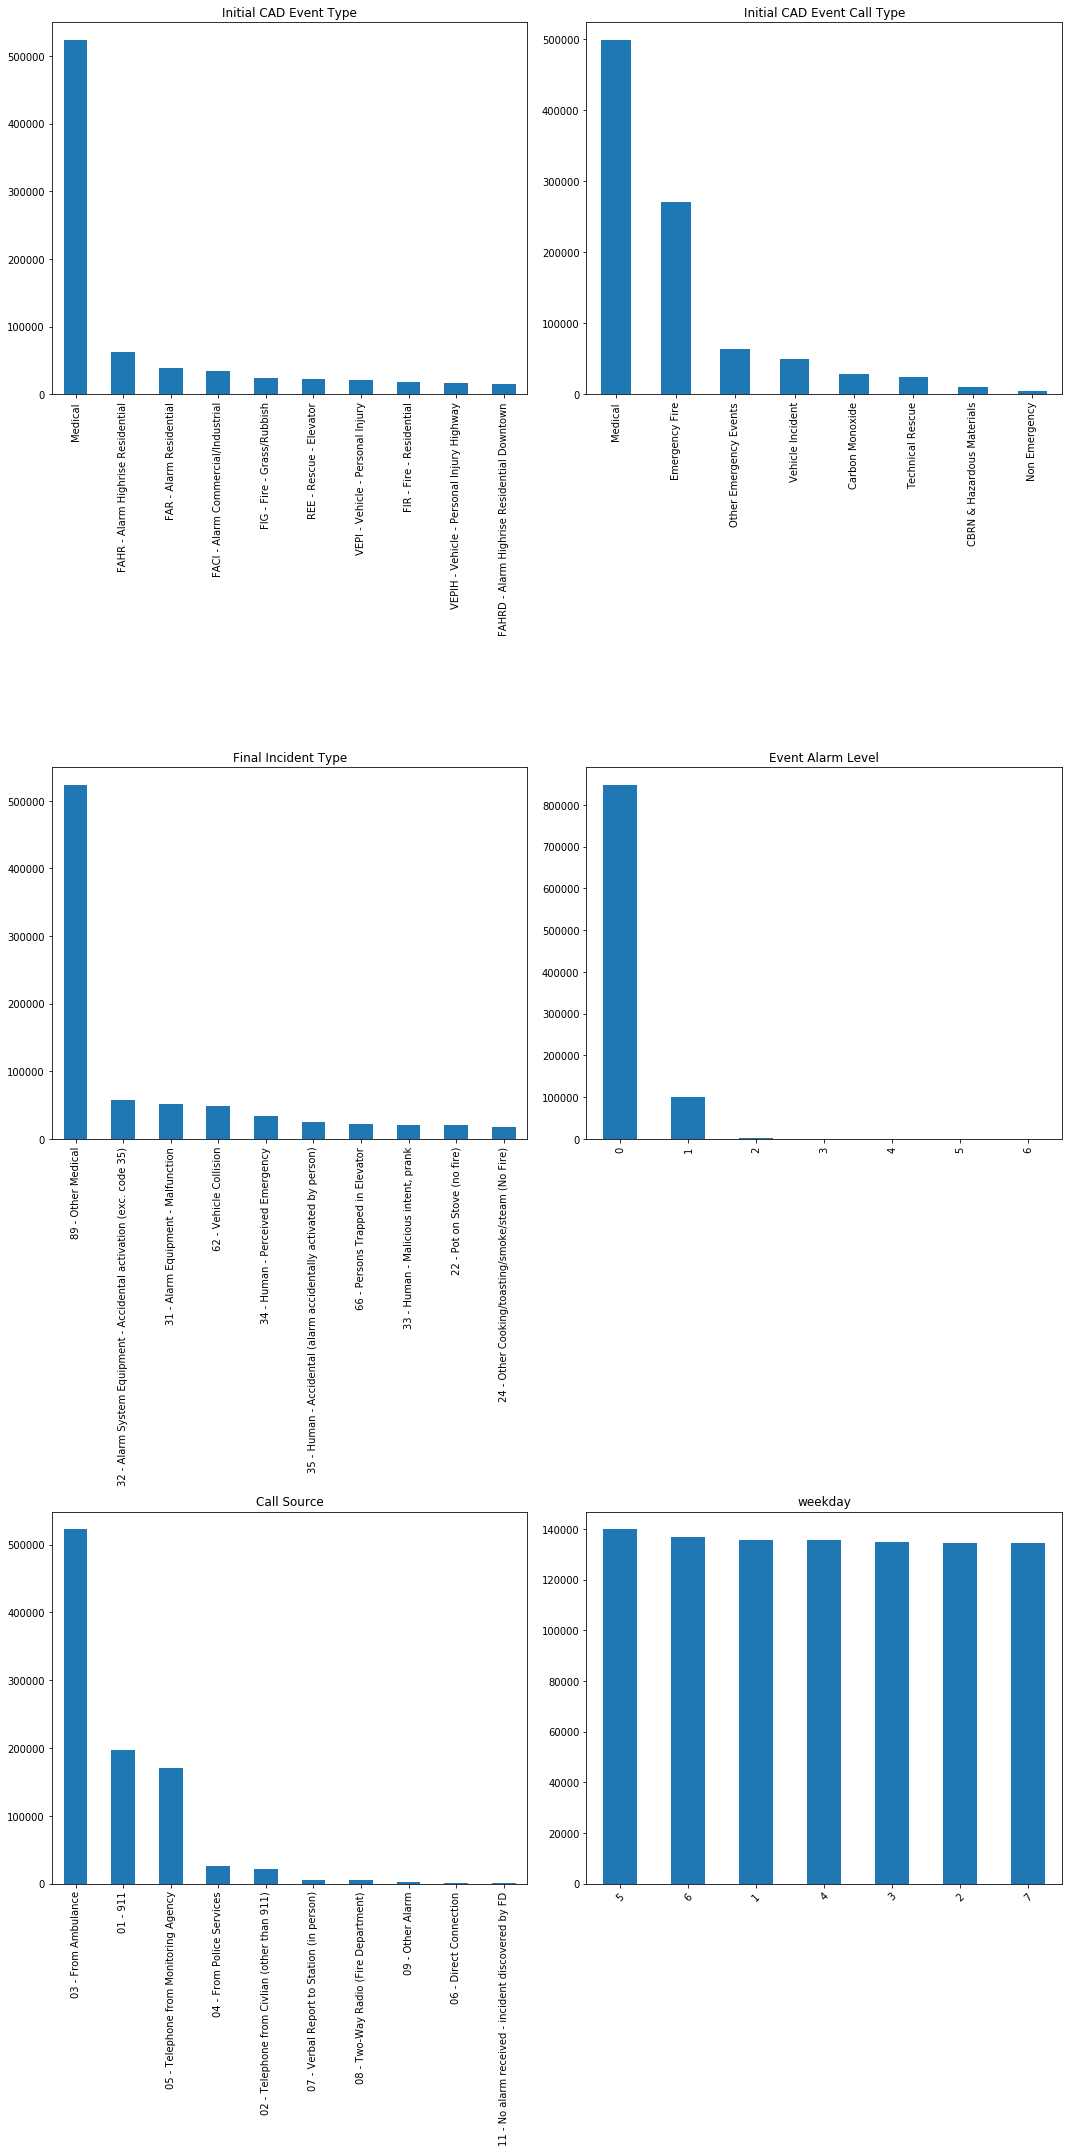

In [20]:
# histograms on breakdown of metadata 

fig, axes= plt.subplots(nrows=3, ncols=2)
# fig.delaxes(ax[3,1])

for index, i in enumerate(qual):
    
    ix = np.unravel_index(index, axes.shape)
    df_all[i].value_counts()[:10].plot(kind='bar', figsize=(15,30), ax=axes[ix], title=i)

    plt.xticks(rotation=45)

    plt.tight_layout()
plt.show()



## Observations from EDA:

- most call and incident type events are medical related
- highly imbalaced class
- will be interested in zooming in on medical event types
- did the initial event type or call type change after determining the final incident type?

In [27]:
for i in range(8):
    
    df[i].dropna(inplace=True)
    df[i].drop_duplicates(inplace=True)
    
    
    df[i][["TFS Alarm Time", 
        "TFS Arrival Time", 
        "Last TFS Unit Clear Time"]] = df[i][["TFS Alarm Time", 
                                               "TFS Arrival Time", 
                                               "Last TFS Unit Clear Time"]].apply(pd.to_datetime)

    
    print(f'size of 201{i+1} dataset: {df[i].shape}')

size of 2011 dataset: (142721, 16)
size of 2012 dataset: (118150, 16)
size of 2013 dataset: (107043, 16)
size of 2014 dataset: (109056, 16)
size of 2015 dataset: (112601, 16)
size of 2016 dataset: (113613, 16)
size of 2017 dataset: (118532, 16)
size of 2018 dataset: (129842, 16)


In [46]:
df[0].head()

,Incident Number,Initial CAD Event Type,Initial CAD Event Call Type,Final Incident Type,Event Alarm Level,Call Source,Incident Station Area,Incident Ward,LATITUDE,Longitude,Intersection,TFS Alarm Time,TFS Arrival Time,Last TFS Unit Clear Time,Persons Rescued,filename,month
0,F11000010,Medical,Medical,89 - Other Medical,1,03 - From Ambulance,342.0,9,43.679099,-79.461761,Silverthorn Ave / Turnberry Ave,2011-01-01 00:03:43,2011-01-01 00:10:02,2011-01-01 00:31:18,0.0,2011_Basic_Incident_Details.csv,1
1,F11000011,Medical,Carbon Monoxide,89 - Other Medical,1,01 - 911,131.0,15,43.726342,-79.396401,Lawrence Ave E / Mount Pleasant Rd,2011-01-01 00:03:55,2011-01-01 00:09:02,2011-01-01 00:15:13,0.0,2011_Basic_Incident_Details.csv,1
2,F11000012,Medical,Medical,89 - Other Medical,1,03 - From Ambulance,324.0,14,43.668548,-79.335324,Endean Ave / Jones Ave,2011-01-01 00:05:03,2011-01-01 00:09:34,2011-01-01 00:27:11,0.0,2011_Basic_Incident_Details.csv,1
3,F11000013,FIG - Fire - Grass/Rubbish,Emergency Fire,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",1,01 - 911,345.0,9,43.657123,-79.434313,Dufferin St / Dufferin Park Ave,2011-01-01 00:04:46,2011-01-01 00:10:46,2011-01-01 00:20:39,0.0,2011_Basic_Incident_Details.csv,1
4,F11000014,FAHR - Alarm Highrise Residential,Emergency Fire,"33 - Human - Malicious intent, prank",1,05 - Telephone from Monitoring Agency,142.0,7,43.759840,-79.516182,Driftwood Ave / Wilmont Dr,2011-01-01 00:06:07,2011-01-01 00:11:03,2011-01-01 00:21:11,0.0,2011_Basic_Incident_Details.csv,1


In [45]:
df[0]['month'] = pd.DatetimeIndex(df[0]['TFS Alarm Time']).month

In [62]:
df[0].groupby(df[0]['month']).count()['TFS Alarm Time']

month
1     12336
2     10661
3     11569
4     11457
5     11680
6     12320
7     13107
8     12348
9     12068
10    12332
11    11208
12    11635
Name: TFS Alarm Time, dtype: int64

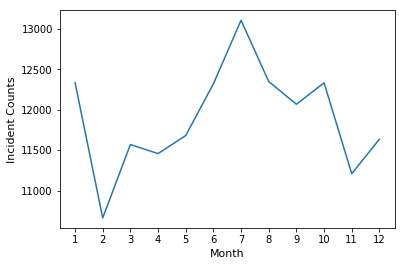

In [171]:
plt.plot(np.arange(1,13), df[0].groupby(df[0]['month']).count()['TFS Alarm Time'])
plt.xticks(np.arange(1,13,1))
plt.xlabel('Month', size=11)
plt.ylabel('Incident Counts', size=11)
plt.show()

In [ ]:
(df[0].groupby(df[0]['month']).count()['TFS Alarm Time']).plot()
plt.axvline(x=7, color='black', style='--')
plt.xticks(np.arange(1,13,1))
plt.xlabel('Month', size=11)
plt.ylabel('Incident Counts', size=11)
plt.show()

In [101]:
np.argmax(df[0].groupby(df[0]['month']).count()['TFS Alarm Time'])

/Users/chengh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


7

In [ ]:
fig, axes= plt.subplots(nrows=3, ncols=2)
# fig.delaxes(ax[3,1])

for index, i in enumerate(qual):
    
    ix = np.unravel_index(index, axes.shape)
    df_all[i].value_counts()[:10].plot(kind='bar', figsize=(15,30), ax=axes[ix], title=i)

    plt.xticks(rotation=45)

    plt.tight_layout()
plt.show()


In [148]:
df[0].groupby(df[0]['month']).count()['TFS Alarm Time'].max()

13107

In [ ]:
# fig, axes= plt.subplots(nrows=4, ncols=2)

# for i in range(8):
    

#     df[i]['month'] = pd.DatetimeIndex(df[i]['TFS Alarm Time']).month

#     ix = np.unravel_index(i, axes.shape)
#     (df[i].groupby(df[i]['month']).count()['TFS Alarm Time']).plot(ax=axes[ix],
#                                                                    figsize=(15,17),
#                                                                   xticks=np.arange(1,13,1))
    
#     plt.xticks(np.arange(1,13,1))
#     plt.tight_layout()
# plt.show()



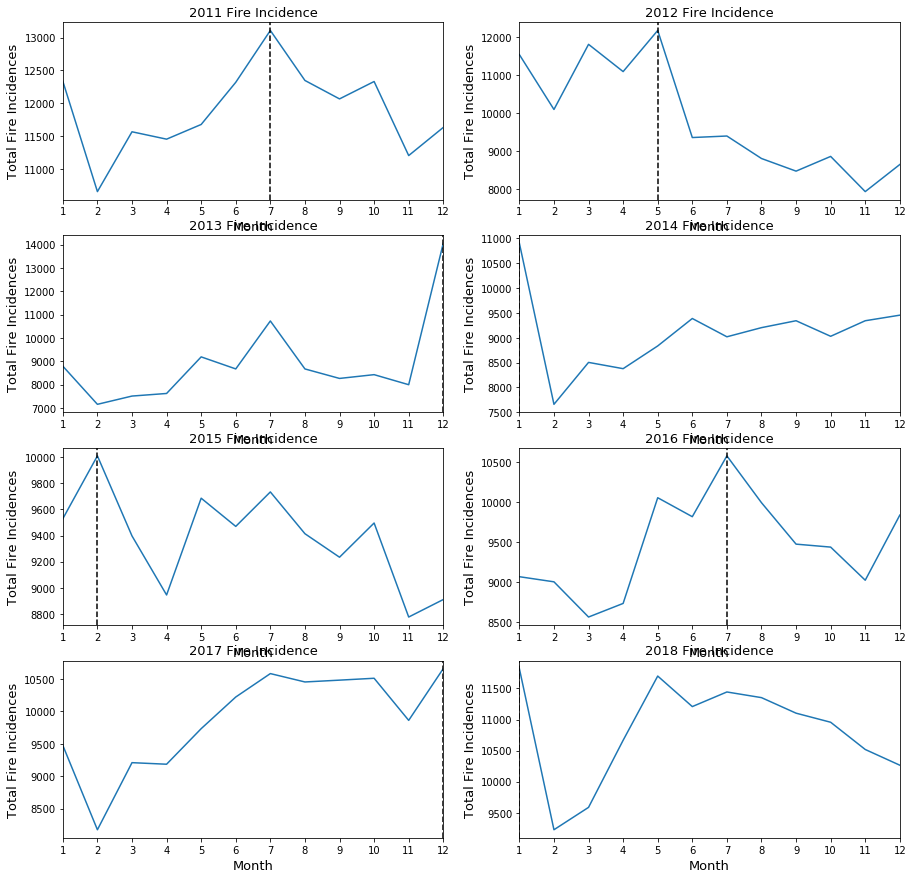

In [218]:
fig, axes= plt.subplots(nrows=4, ncols=2, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    

    df[i]['month'] = pd.DatetimeIndex(df[i]['TFS Alarm Time']).month
    maximum = df[i].groupby(df[i]['month']).count()['TFS Alarm Time'].values.argmax() + 1

    ix = np.unravel_index(i, axes.shape)

#     (df[i].groupby(df[i]['month']).count()['TFS Alarm Time']).plot(ax=axes[ix],
#                                                                    figsize=(15,17),
#                                                                   xticks=np.arange(1,13,1))
    
    ax.plot(np.arange(1,13), df[i].groupby(df[i]['month']).count()['TFS Alarm Time'])
                                                              

    ax.axvline(x=maximum, color='black', linestyle='--', )
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xlabel('Month', size=13)
    ax.set_ylabel('Total Fire Incidences', size=13)
    ax.set_title(f'201{i+1} Fire Incidence', size=13)
    ax.set_xlim(1,12)

plt.show()
